# Analyse des Keuzkorrelationstrackings

Das Kreuzkorrelationstrackign ist eine Technik, um Verschiebungen zwischen zwei Bildern zu ermitteln.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

In [3]:
import pandas as pd
import fixed_colourbar as fc

## Beispiel von scikit-image

Zuerst sehen wir uns mal das Beispiel von der scikit-image-Website an.

In [4]:
image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print("Known offset (y, x): {}".format(shift))

Known offset (y, x): (-22.4, 13.32)


In [5]:
# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

In [6]:
shift

array([ 22., -13.])

In [7]:
error

0.039711906347899784

In [8]:
diffphase

-1.1216836125916841e-06

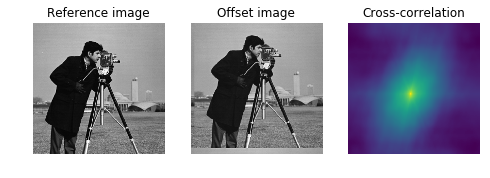

Detected pixel offset (y, x): [ 22. -13.]


In [9]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

In [10]:
# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

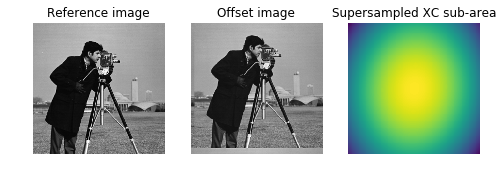

Detected subpixel offset (y, x): [ 22.4  -13.32]


In [11]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))

Die Funktion register_translation erlaubt es Verschiebungen von ganzen oder auch teilweisen Pixeln zu registrieren.

Als nächstes sehen wir uns das mal anhand von Satellitendaten an.

## Fallbeispiel

Dafür laden wir uns ein Beispiel.

In [12]:
import datetime as dt
import xarray as xr
from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210,vmax=300)

In [13]:
beispiel = xr.open_dataset("/vols/talos/home/stephan/data/radar_track/trackdata/haci_trackdata_20130618_88.nc")

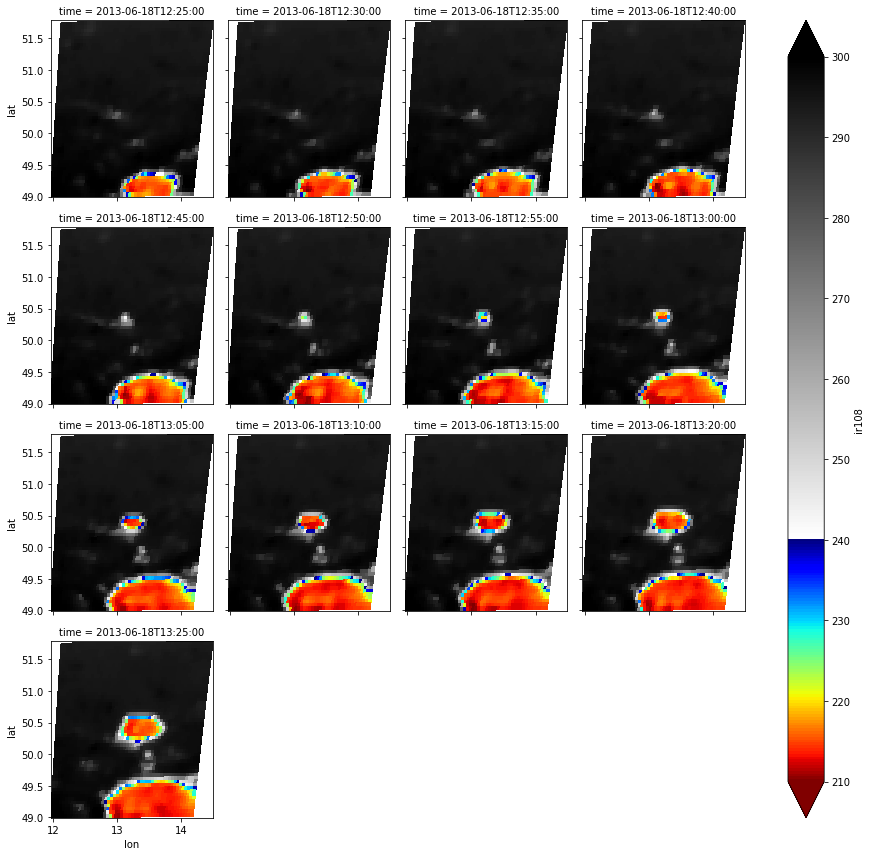

In [14]:
beispiel.ir108.plot(x='lon',y='lat',col='time',col_wrap=4,vmin=210,vmax=300,cmap=emap)

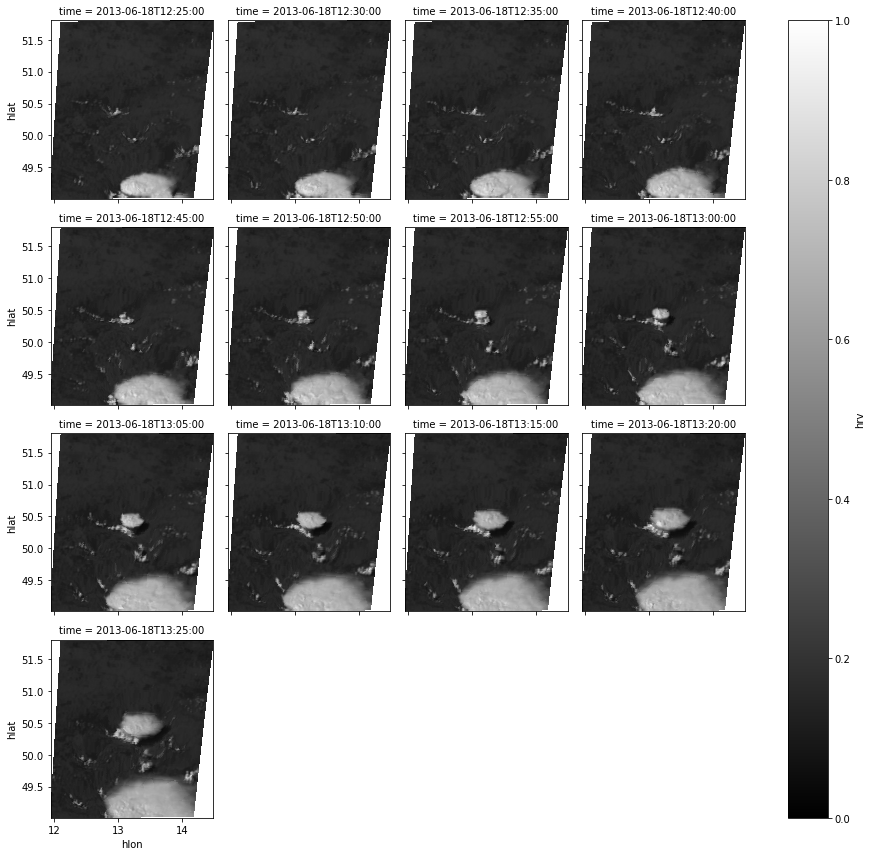

In [15]:
beispiel.hrv.plot(x='hlon',y='hlat',col='time',col_wrap=4,vmin=0,vmax=1,cmap='gray')

Als nächstes sehen wir uns die Verschiebung für ganze Trackausschnitte des HRV-Kanals an.

In [16]:
shift, error, diffphase = register_translation(beispiel.hrv.data[6], beispiel.hrv.data[7])

In [17]:
print(r"Verschiebung (Zeile, Spalte): ({},{}) +/- {:01.2f} px".format(shift[0],shift[1],error))

Verschiebung (Zeile, Spalte): (0.0,-1.0) +/- 0.17 px


Die sich ergebende Verschiebung beträgt also 0 px in Zeilenrichtung und -1 px in Spaltenrichtung.

Sehen wir uns das doch mal an.

In [18]:
# Abbildugn der Phasenkorrelation
image_product = np.fft.fft2(beispiel.hrv.data[6]) * np.fft.fft2(beispiel.hrv.data[7]).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))

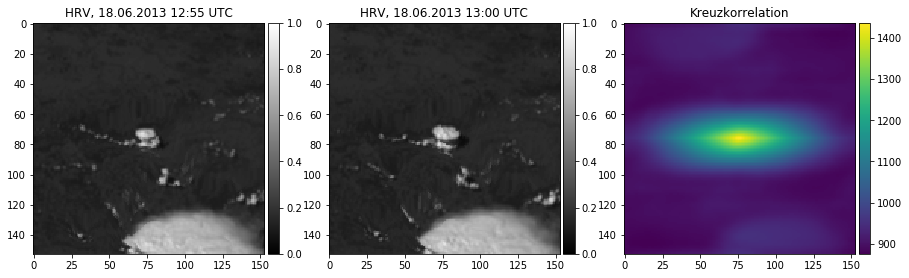

In [19]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
hrv0_plot = ax[0].imshow(beispiel.hrv.data[6],vmin=0,vmax=1,cmap='gray')
ax[0].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv0_plot)

hrv1_plot = ax[1].imshow(beispiel.hrv.data[7],vmin=0,vmax=1,cmap='gray')
ax[1].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv1_plot)

cc_plot = ax[2].imshow(cc_image.real)
ax[2].set_title("Kreuzkorrelation")
fc.colourbar(cc_plot)

Es ist auch möglich Subpixelverschiebungen zu registrieren.

In [20]:
shift, error, diffphase = register_translation(beispiel.hrv.data[6], beispiel.hrv.data[7],100)

In [21]:
print(r"Verschiebung (Zeile, Spalte): ({},{}) +/- {:01.2f} px".format(shift[0],shift[1],error))

Verschiebung (Zeile, Spalte): (0.04,-0.79) +/- 0.17 px


In [22]:
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()

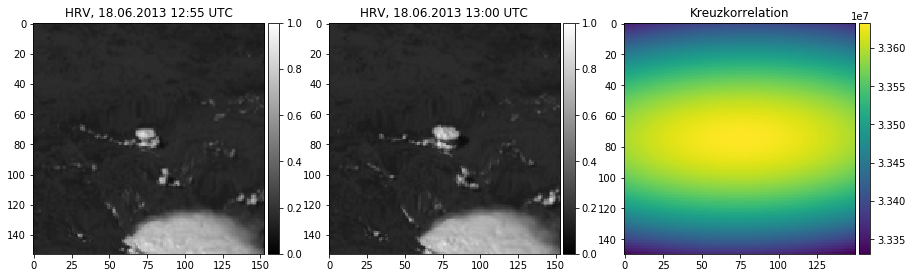

In [23]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
hrv0_plot = ax[0].imshow(beispiel.hrv.data[6],vmin=0,vmax=1,cmap='gray')
ax[0].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv0_plot)

hrv1_plot = ax[1].imshow(beispiel.hrv.data[7],vmin=0,vmax=1,cmap='gray')
ax[1].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv1_plot)

cc_plot = ax[2].imshow(cc_image.real)
ax[2].set_title("Kreuzkorrelation")
fc.colourbar(cc_plot)

## Unterteilung in Unterbereiche

Auf diese Weise bekommt man nur eine Verschiebung pro Trackausschnitt. Eine Variante, die mehrere Verschiebungen erlaubt, ist, dass man die Bilder in Ausschnitte unterteilt und separate Verschiebungen für diese ermittelt. 

Dafür definieren wir zunächste eine Funktion, die eine gegebene Matrix in Teilbereiche zerlegt.

In [24]:
def partitionate_array(array, box_size):
    """
    Partionate a given array into boxes of given size.

    Parameters
    ----------
    array: 2d array of integers or floats
        source array to partionate
    box_size: integer
        size of the boxes to partitionate the array in, has to be an integer divisor of the array shape

    Returns
    -------
    splits: list of array   
        boxes of the source array
    idx_row: list of arrays
        row index coordinates of the boxes relative to the source array
    idx_col: list of arrays
        col index coordinates of the boxes relative to the source array
    """
    
    try:
        # get size of the boxes
        shape_row = array.shape[0]
        shape_col = array.shape[1]

        n_boxes_row = shape_row / box_size
        n_boxes_col = shape_col / box_size

        # create index set to track the parts
        index_set = np.meshgrid(np.arange(0,shape_row),
                                np.arange(0,shape_col))

        # split array 
        splits_row = np.split(array, n_boxes_row,axis = 0)
        splits_row_id = np.split(index_set[0], n_boxes_row,axis = 0)
        splits_col_id = np.split(index_set[1], n_boxes_row,axis = 0)

        splits = []
        idx_row = []
        idx_col = []

        for i,sp in enumerate(splits_row):
            splits.extend(np.array_split(sp, n_boxes_col, axis=1))
            idx_row.extend(np.array_split(splits_row_id[i], n_boxes_col, axis=1))
            idx_col.extend(np.array_split(splits_col_id[i], n_boxes_col, axis=1))

        return splits, idx_row,idx_col
    except ValueError:
        print("The given box size is not an integer divisor of the array shape.")
        return

In [25]:
def partitionate_array(array, box_size):
    """
    Partionate a given array into boxes of given size.

    Parameters
    ----------
    array: 2d array of integers or floats
        source array to partionate
    box_size: integer
        size of the boxes to partitionate the array in, has to be an integer divisor of the array shape

    Returns
    -------
    splits: list of array   
        boxes of the source array
    idx_row: list of arrays
        row index coordinates of the boxes relative to the source array
    idx_col: list of arrays
        col index coordinates of the boxes relative to the source array
    """
    
    try:
        # get size of the boxes
        shape_row = array.shape[0]
        shape_col = array.shape[1]

        n_boxes_row = shape_row / box_size
        n_boxes_col = shape_col / box_size

        # create index set to track the parts
        index_set = np.meshgrid(np.arange(0,shape_row),
                                np.arange(0,shape_col),indexing='ij')

        # split array 
        splits_row = np.split(array, n_boxes_row,axis = 0)
        splits_row_id = np.split(index_set[0], n_boxes_row,axis = 0)
        splits_col_id = np.split(index_set[1], n_boxes_row,axis = 0)

        splits = []
        idx_row = []
        idx_col = []

        for i,sp in enumerate(splits_row):
            splits.extend(np.array_split(sp, n_boxes_col, axis=1))
            idx_row.extend(np.array_split(splits_row_id[i], n_boxes_col, axis=1))
            idx_col.extend(np.array_split(splits_col_id[i], n_boxes_col, axis=1))

        return splits, idx_row,idx_col
    except ValueError:
        print("The given box size is not an integer divisor of the array shape.")
        return

Eine sinnvolle Unterteilung ist nur für ganzzahlige Teiler der Bilddimensionen möglich. Dafür definieren wir auch eine Funktion.

In [26]:
def get_integer_divisors(number):
    divisors = []
    i=1
    
    while i <= number:
        if number % i == 0:
            divisor = number//i        
            divisors.append(divisor)
            i += 1

        else:
            i += 1

    divisors.reverse()
    return divisors

Aber vielleicht ergeben sich ja auch sinnvolle Unterteilungen für nichtganzzahlige Teiler. Die numpy funktion split_array erlaubt das.

In [27]:
array = beispiel.hrv.data[6]
box_size=10

In [28]:
# get size of the boxes
shape_row = array.shape[0]
shape_col = array.shape[1]

print(u"Matrixdimension: {} Zeilen x {} Spalten".format(shape_row,shape_col))

Matrixdimension: 153 Zeilen x 153 Spalten


In [29]:
n_boxes_row = shape_row / box_size
n_boxes_col = shape_col / box_size

print(u"Anzahl von Unterteilungen: {} x {} ".format(n_boxes_row,n_boxes_col))

Anzahl von Unterteilungen: 15 x 15 


In [30]:
splits_row = np.array_split(array, n_boxes_row,axis = 0)

In [31]:
for s in splits_row:
    print s.shape

(11, 153)
(11, 153)
(11, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)
(10, 153)


Diese Unterteilung ist ein wenig unintuitiv. Es ist deshalb wahrscheinlich sinnvoller nur ganzzahlige Teiler der Matrixdimensionen zuzulassen.

In [32]:
integer_divisors = get_integer_divisors(beispiel.hrv.data[6].shape[0])
print integer_divisors

[1, 3, 9, 17, 51, 153]


In [33]:
box_size = 9

In [34]:
hrv0_part,rows,cols = partitionate_array(beispiel.hrv.data[6],box_size)
hrv1_part,rows,cols = partitionate_array(beispiel.hrv.data[7],box_size)

In [35]:
shift = np.zeros((2,beispiel.hrv.data[6].shape[0],beispiel.hrv.data[6].shape[1]))
cc_img = []

for i, s in enumerate(hrv0_part):
    ishift = register_translation(s,
                                  hrv1_part[i],
                                  1,
                                  'real')[0]
    
    image_product = np.fft.fft2(s) * np.fft.fft2(hrv1_part[i]).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    
    cc_img.append(cc_image.real)
    
    shift[0][rows[i],cols[i]] = ishift[0]
    shift[1][rows[i],cols[i]] = ishift[1]

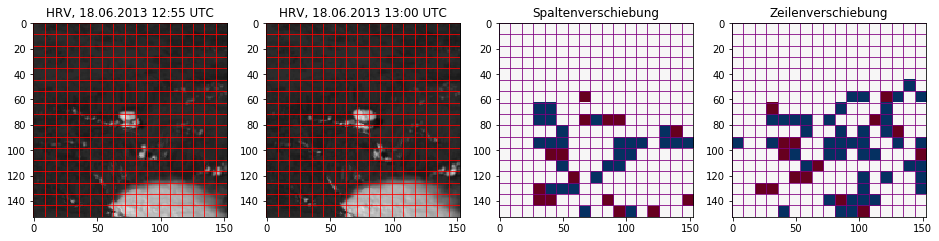

In [36]:
fig,ax = plt.subplots(1,4,figsize=(16,5))
ax[0].imshow(beispiel.hrv.data[6],vmin=0,vmax=1,cmap='gray')
ax[0].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))

for i in np.arange(-0.5,beispiel.hrv.data[6].shape[0]+0.5,box_size):
    ax[0].axhline(y=i,color='red',linestyle='-',linewidth=0.8)
    ax[0].axvline(x=i,color='red',linestyle='-',linewidth=0.8)
    
ax[1].imshow(beispiel.hrv.data[7],vmin=0,vmax=1,cmap='gray')
ax[1].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M UTC")))

for i in np.arange(0,beispiel.hrv.data[6].shape[0]+1,box_size):
    ax[1].axhline(y=i-0.5,color='red',linestyle='-',linewidth=0.8)
    ax[1].axvline(x=i-0.5,color='red',linestyle='-',linewidth=0.8)

ax[2].imshow(shift[0],vmin=-1,vmax=1,cmap='RdBu_r')
ax[2].set_title("Spaltenverschiebung")

for i in np.arange(0,beispiel.hrv.data[6].shape[0]+1,box_size):
    ax[2].axhline(y=i-0.5,color='purple',linestyle='-',linewidth=0.8)
    ax[2].axvline(x=i-0.5,color='purple',linestyle='-',linewidth=0.8)

ax[3].imshow(shift[1],vmin=-1,vmax=1,cmap='RdBu_r')
ax[3].set_title("Zeilenverschiebung")

for i in np.arange(0,beispiel.hrv.data[6].shape[0]+1,box_size):
    ax[3].axhline(y=i-0.5,color='purple',linestyle='-',linewidth=0.8)
    ax[3].axvline(x=i-0.5,color='purple',linestyle='-',linewidth=0.8)

Bei der Zuordnung der Verschiebungen in die Verschiebungsmatrizen läuft etwas schief. Oben rechts sollte die Spaltenverschiebung 0 sein ist aber 1 und unten rechts, wo sie &ne; 0 sein sollte ist sie 0. Die Zeilenverschiebung sollte auch eher Werte &ne; 0 entlang der mitteleren Horizontalen anstatt Vertikalen haben.

Text(0.5,1,u'Spaltenverschiebung / px')

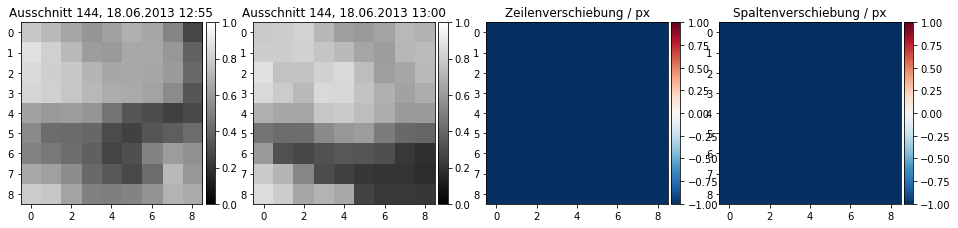

In [37]:
dim = (beispiel.hrv.data[6].shape[0] // box_size,
       beispiel.hrv.data[6].shape[1] // box_size)
point = (beispiel.hrv.data[6].shape[0]// box_size // 2,beispiel.hrv.data[6].shape[1]// box_size // 2)

idx = np.ravel_multi_index(point,dim)

fig,ax = plt.subplots(1,4,figsize=(16,5))
h0p = ax[0].imshow(hrv0_part[idx],vmin=0,vmax=1,cmap='gray')
fc.colourbar(h0p)
ax[0].set_title("Ausschnitt {}, {}".format(idx,
                                                pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M")))

h1p = ax[1].imshow(hrv1_part[idx],vmin=0,vmax=1,cmap='gray')
fc.colourbar(h1p)
ax[1].set_title("Ausschnitt {}, {}".format(idx,
                                                pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M")))

rp = ax[2].imshow(shift[0][rows[idx],cols[idx]],vmin=-1,vmax=1,cmap='RdBu_r')
fc.colourbar(rp)
ax[2].set_title(u"Zeilenverschiebung / px")

cp = ax[3].imshow(shift[1][rows[idx],cols[idx]],vmin=-1,vmax=1,cmap='RdBu_r')
fc.colourbar(cp)
ax[3].set_title(u"Spaltenverschiebung / px")

In [38]:
import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking")
import tracking_common as tco

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [39]:
hrv0_morphed = tco.morph_field(beispiel.hrv.data[6],shift[0],shift[1])

Text(0.5,1,'Differenz')

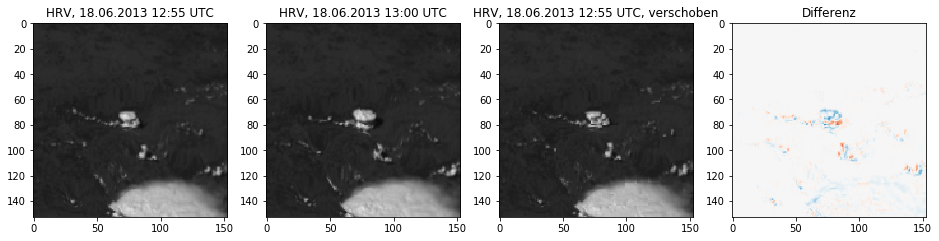

In [40]:
fig,ax = plt.subplots(1,4,figsize=(16,5))
ax[0].imshow(beispiel.hrv.data[6],vmin=0,vmax=1,cmap='gray')
ax[0].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))

ax[1].imshow(beispiel.hrv.data[7],vmin=0,vmax=1,cmap='gray')
ax[1].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M UTC")))

ax[2].imshow(hrv0_morphed,vmin=0,vmax=1,cmap='gray')
ax[2].set_title("HRV, {}, verschoben".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))

ax[3].imshow(hrv0_morphed-beispiel.hrv.data[7],vmin=-1,vmax=1,cmap='RdBu_r')
ax[3].set_title("Differenz")

Eine weitere mögliche Anpassung ist, den Suchbereich größer zu machen, als den Ausgangsbereich. Das sollte für eine genauere Verschiebungsermittlung sorgen. Dabei entsteht allerdings das Problem, dass die Ausgangs- und Zielbereiche unterschiedliche Größen haben. Die Funktion register_translation erwartet allerdings gleich große Bereiche. Abhilfe kann hier die numpy-Funktion pad schaffen.


In [41]:
hrv0_part,rows0,cols0 = partitionate_array(beispiel.hrv.data[6],box_size)
hrv1_part,rows1,cols1 = partitionate_array(beispiel.hrv.data[7],17)

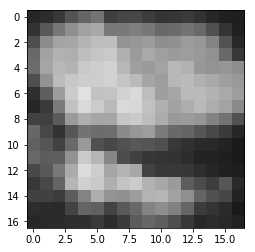

In [42]:
plt.imshow(hrv1_part[len(hrv1_part)/2],vmin=0,vmax=1,cmap='gray')

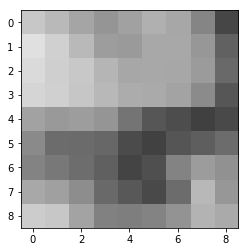

In [43]:
plt.imshow(hrv0_part[len(hrv0_part)/2],vmin=0,vmax=1,cmap='gray')

In [44]:
cut0 = hrv0_part[len(hrv0_part)/2]
cut1 = hrv1_part[len(hrv1_part)/2]

In [45]:
cut0 = np.pad(cut0,(8,8),'constant')

In [46]:
cut0.shape

(25, 25)

In [47]:
cut1 = np.pad(cut1,(4,4),'constant')

In [48]:
cut1.shape

(25, 25)

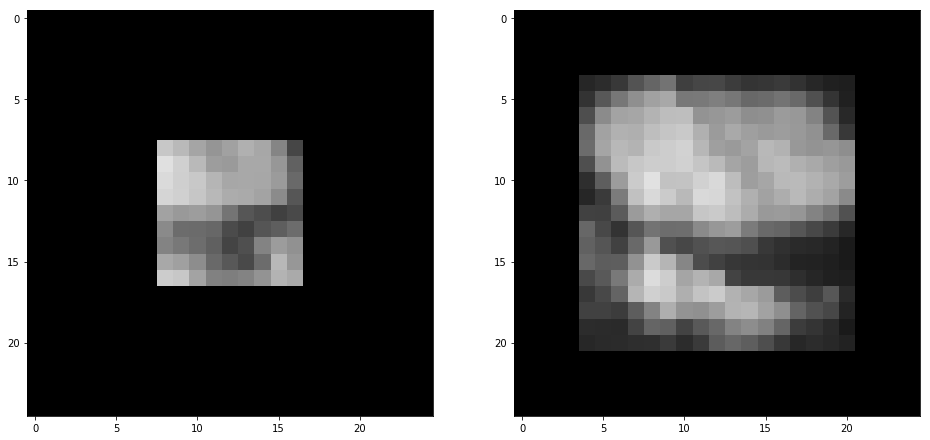

In [49]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(cut0,vmin=0,vmax=1,cmap='gray')
ax[1].imshow(cut1,vmin=0,vmax=1,cmap='gray')

In [50]:
shift, error, diffphase = register_translation(cut0,cut1,100)

In [51]:
print("Verschiebung: {}, Fehler: {}".format(shift,error))

Verschiebung: [3.16 0.85], Fehler: 0.765154658088


In [52]:
image_product = np.fft.fft2(cut0) * np.fft.fft2(cut1).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))

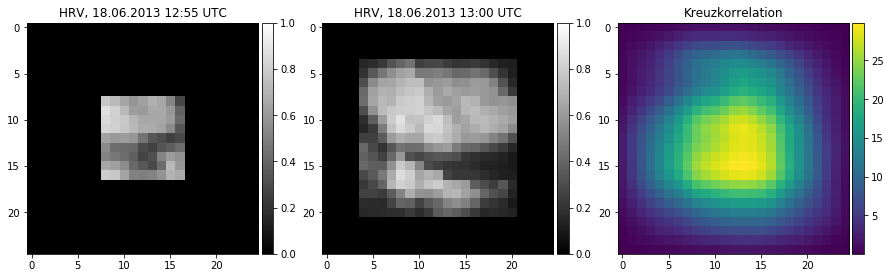

In [53]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
hrv0_plot = ax[0].imshow(cut0,vmin=0,vmax=1,cmap='gray')
ax[0].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv0_plot)

hrv1_plot = ax[1].imshow(cut1,vmin=0,vmax=1,cmap='gray')
ax[1].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv1_plot)

cc_plot = ax[2].imshow(cc_image.real)
ax[2].set_title("Kreuzkorrelation")
fc.colourbar(cc_plot)

Das liefert viel realistischere Verschiebungswerte. Also sollten wir diesen Ansatz verwenden.

In [54]:
box_size1 = 17

In [55]:
infl = (box_size1 - box_size) // 2

In [145]:
shift_array = np.zeros((2,beispiel.hrv.data[6].shape[0],beispiel.hrv.data[6].shape[1]))
cc_img = []

In [146]:
for i, s in enumerate(hrv0_part):
    s0 = np.pad(s,(infl+4,infl+4),'constant')
    
    r = rows[i].shape[0]
    c = rows[i].shape[1]
    
    r1_min = np.min(rows[i])-infl
    r1_max = np.max(rows[i])+infl+1
    c1_min = np.min(cols[i])-infl
    c1_max = np.max(cols[i])+infl+1
    
    if r1_min < 0:
        row_pad_min = 4 - r1_min
        r1_min = 0
    else:
        row_pad_min = 4
    
    if r1_max > beispiel.hrv.data[6].shape[0]:
        row_pad_max = 4 + r1_max - beispiel.hrv.data[6].shape[0]
        r1_max = beispiel.hrv.data[6].shape[0]
    else:
        row_pad_max = 4
        
    if c1_min < 0:
        col_pad_min = 4 - c1_min
        c1_min = 0
    else:
        col_pad_min = 4
    
    if c1_max > beispiel.hrv.data[6].shape[0]:
        col_pad_max = 4 + c1_max - beispiel.hrv.data[6].shape[1]
        c1_max = beispiel.hrv.data[6].shape[1]
    else:
        col_pad_max = 4        
    
    s1 = np.pad(beispiel.hrv.data[7][r1_min:r1_max,c1_min:c1_max],
                [(row_pad_min,row_pad_max),(col_pad_min, col_pad_max)],'constant')
    
    ishift = register_translation(s0,s1,1,'real')[0]
    
    image_product = np.fft.fft2(s0) * np.fft.fft2(s1).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    
    cc_img.append(cc_image.real)
    
    shift_array[0][rows[i],cols[i]] = ishift[0]
    shift_array[1][rows[i],cols[i]] = ishift[1]

In [130]:
s0 = np.pad(hrv0_part[0],(infl+4,infl+4),'constant')

In [131]:
print(s0.shape)

(25, 25)


In [132]:
r = rows[0].shape[0]
c = rows[0].shape[1]

In [133]:
print r,c

9 9


In [134]:
r1_min = np.min(rows[0])-infl
r1_max = np.max(rows[0])+infl+1
c1_min = np.min(cols[0])-infl
c1_max = np.max(cols[0])+infl+1

print r1_min, r1_max,c1_min,c1_max

-4 13 -4 13


In [135]:
if r1_min < 0:
        row_pad_min = 4 - r1_min
        r1_min = 0
else:
    row_pad_min = 4

if r1_max > beispiel.hrv.data[6].shape[0]:
    row_pad_max = 4 + r1_max - beispiel.hrv.data[6].shape[0]
    r1_max = beispiel.hrv.data[6].shape[0]
else:
    row_pad_max = 4

if c1_min < 0:
    col_pad_min = 4 - c1_min
    c1_min = 0
else:
    col_pad_min = 4

if c1_max > beispiel.hrv.data[6].shape[0]:
    col_pad_max = 4 + c1_max - beispiel.hrv.data[6].shape[1]
    c1_max = beispiel.hrv.data[6].shape[1]
else:
        col_pad_max = 4      

In [136]:
row_pad_min,row_pad_max,col_pad_min,col_pad_max

(8, 4, 8, 4)

In [137]:
s1 = np.pad(beispiel.hrv.data[7][r1_min:r1_max,c1_min:c1_max],
                [(row_pad_min,row_pad_max),(col_pad_min, col_pad_max)],'constant')

In [138]:
s1.shape

(25, 25)

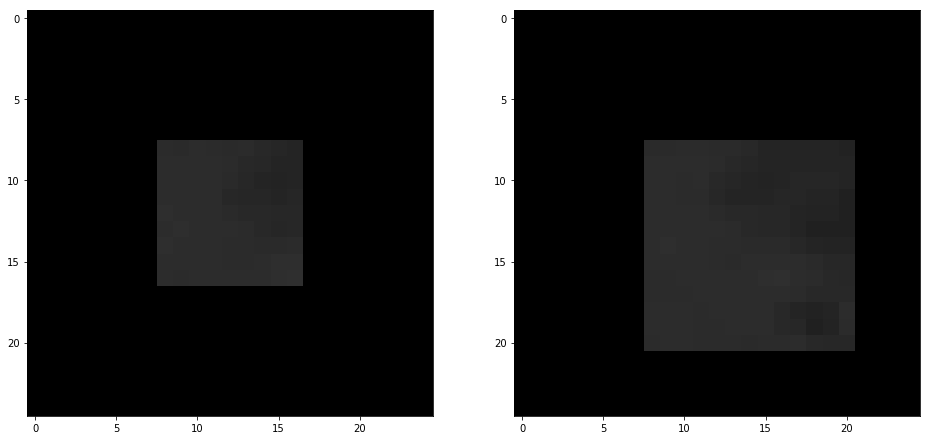

In [139]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(s0,vmin=0,vmax=1,cmap='gray')
ax[1].imshow(s1,vmin=0,vmax=1,cmap='gray')

In [140]:
ishift = register_translation(s0,s1,1,'real')[0]

In [141]:
ishift

array([-4.,  0.])

In [100]:
print("Verschiebung: {}, Fehler: {}".format(shift,error))

Verschiebung: [-4.  0.], Fehler: 0.685311623573


In [142]:
image_product = np.fft.fft2(s0) * np.fft.fft2(s1).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))

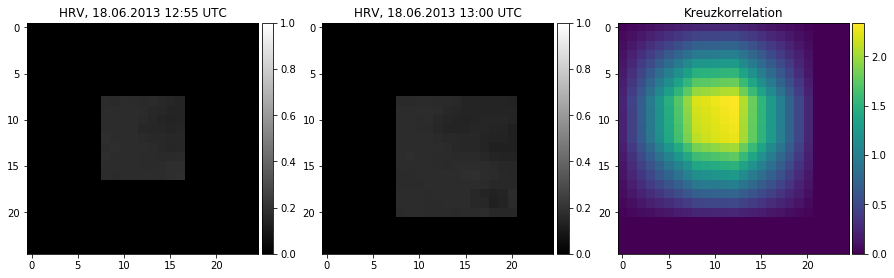

In [143]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
hrv0_plot = ax[0].imshow(s0,vmin=0,vmax=1,cmap='gray')
ax[0].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv0_plot)

hrv1_plot = ax[1].imshow(s1,vmin=0,vmax=1,cmap='gray')
ax[1].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M UTC")))
fc.colourbar(hrv1_plot)

cc_plot = ax[2].imshow(cc_image.real)
ax[2].set_title("Kreuzkorrelation")
fc.colourbar(cc_plot)

Text(0.5,1,'spaltenweise Verschiebung')

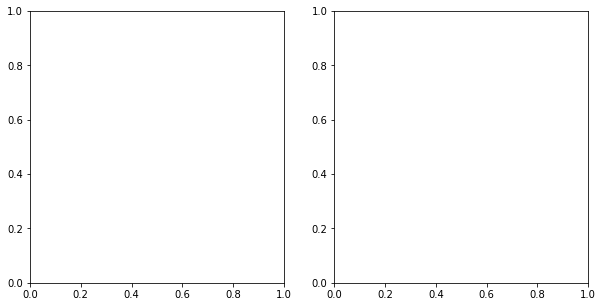

In [157]:
fig.ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(shift_array[0])
ax[0].set_title("zeilenweise Verschiebung")
ax[1].imshow(shift_array[1])
ax[1].set_title("spaltenweise Verschiebung")

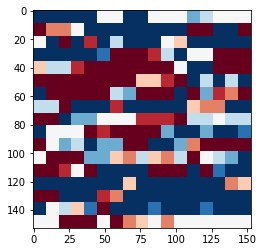

In [159]:
plt.imshow(shift_array[0],vmin=-4,vmax=4,cmap='RdBu_r')

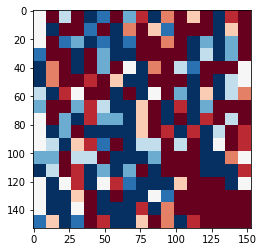

In [160]:
plt.imshow(shift_array[1],vmin=-4,vmax=4,cmap='RdBu_r')

In [161]:
hrv0_morphed = tco.morph_field(beispiel.hrv.data[6],shift_array[0],shift_array[1])

Text(0.5,1,'Differenz')

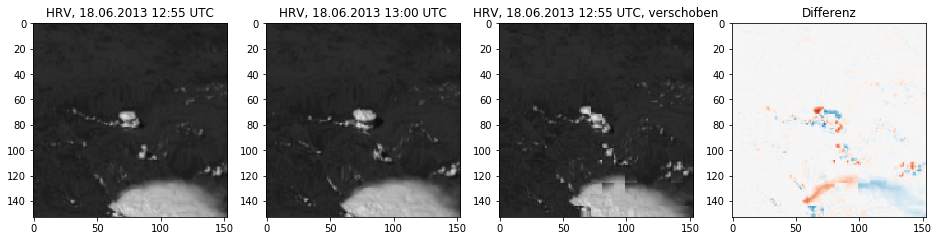

In [162]:
fig,ax = plt.subplots(1,4,figsize=(16,5))
ax[0].imshow(beispiel.hrv.data[6],vmin=0,vmax=1,cmap='gray')
ax[0].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))

ax[1].imshow(beispiel.hrv.data[7],vmin=0,vmax=1,cmap='gray')
ax[1].set_title("HRV, {}".format(pd.Timestamp(beispiel.time.data[7]).strftime("%d.%m.%Y %H:%M UTC")))

ax[2].imshow(hrv0_morphed,vmin=0,vmax=1,cmap='gray')
ax[2].set_title("HRV, {}, verschoben".format(pd.Timestamp(beispiel.time.data[6]).strftime("%d.%m.%Y %H:%M UTC")))

ax[3].imshow(hrv0_morphed-beispiel.hrv.data[7],vmin=-1,vmax=1,cmap='RdBu_r')
ax[3].set_title("Differenz")